In [1]:
# 加载所需要的包
import warnings
warnings.filterwarnings("ignore")
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense,LeakyReLU,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
# 工作空间设置
os.chdir('C:/Users/23665')
os.getcwd()

'C:\\Users\\23665'

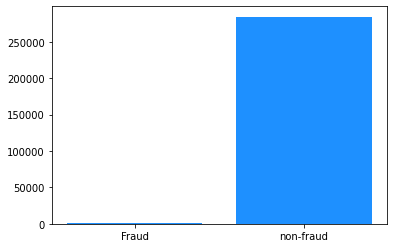

In [2]:
# 读取数据和简单的特征工程
d = pd.read_csv('creditcard.csv')

# 查看样本比例
num_nonfraud = np.sum(d['Class'] == 0)
num_fraud = np.sum(d['Class'] == 1)
plt.bar(['Fraud', 'non-fraud'], [num_fraud, num_nonfraud], color='dodgerblue')
plt.show()

# 删除时间列，对Amount进行标准化
data = d.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data[['Amount']])
X = data.drop(['Class'],axis=1)
Y = data.Class

In [4]:
# 设置Autoencoder的参数
input_dim    = X.shape[1]
encoding_dim = 128
num_epoch    = 30
batch_size   = 256

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, 
                activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5)
                )(input_layer)
encoder =BatchNormalization()(encoder)
encoder=LeakyReLU(alpha=0.2)(encoder)

encoder = Dense(int(encoding_dim/2), 
                activation="relu"
                )(encoder)
encoder =BatchNormalization()(encoder)
encoder=LeakyReLU(alpha=0.1)(encoder)

encoder = Dense(int(encoding_dim/4), 
                activation="relu"
                )(encoder)
encoder =BatchNormalization()(encoder)



### decoder
decoder = LeakyReLU(alpha=0.1)(encoder)
decoder = Dense(int(encoding_dim/4),
                activation='tanh'
                )(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU(alpha=0.1)(decoder)


decoder = Dense(int(encoding_dim/2),
                activation='tanh'
                )(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU(alpha=0.1)(decoder)

decoder = Dense(input_dim, 
                #activation='relu'
                )(decoder)

autoencoder = Model(inputs = input_layer, 
                    outputs = decoder
                    )
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae','mse']
                    )

# 模型保存为 XiaoWuGe_model.h5，并开始训练模型
checkpointer = ModelCheckpoint(filepath="XiaoWuGe_model.h5",
                               verbose=0,
                               save_best_only=True
                               )
history = autoencoder.fit(X, 
                          X,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          #validation_data=(X_test, X_test),
                          verbose=1, 
                          callbacks=[checkpointer]
                          ).history

Epoch 1/30
1113/1113 [==============================] - 12s 6ms/step - loss: 0.3729 - mae: 0.3654 - mse: 0.3683
Epoch 2/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.1528 - mae: 0.2356 - mse: 0.1482
Epoch 3/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.1067 - mae: 0.1936 - mse: 0.1022
Epoch 4/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0896 - mae: 0.1733 - mse: 0.0851
Epoch 5/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0761 - mae: 0.1577 - mse: 0.0716
Epoch 6/30
1113/1113 [==============================] - 7s 7ms/step - loss: 0.0714 - mae: 0.1494 - mse: 0.0669
Epoch 7/30
1113/1113 [==============================] - 7s 6ms/step - loss: 0.0647 - mae: 0.1403 - mse: 0.0603
Epoch 8/30
1113/1113 [==============================] - 7s 7ms/step - loss: 0.0602 - mae: 0.1332 - mse: 0.0557
Epoch 9/30
1113/1113 [==============================] - 7s 7ms/step - loss: 0.0545 - mae: 0.1280 - mse: 0.0501


1113/1113 [==============================] - 8s 7ms/step - loss: 0.0363 - mae: 0.0960 - mse: 0.0319
Epoch 30/30
1113/1113 [==============================] - 8s 7ms/step - loss: 0.0363 - mae: 0.0954 - mse: 0.0319


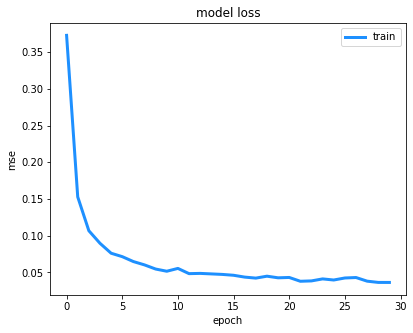

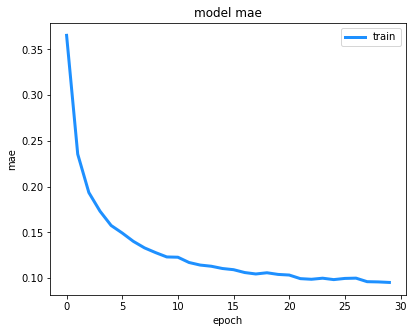

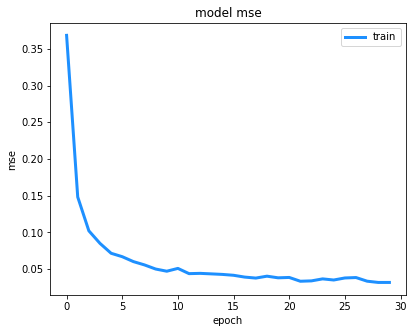

In [5]:
# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')


# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['mse'], c='dodgerblue', lw=3)
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')

In [6]:
# 读取模型
# autoencoder = load_model('SofaSofa_model.h5')

#利用训练好的autoencoder重建测试集
pred_X  = autoencoder.predict(X)
# 计算还原误差MSE和MAE
mse_X = np.mean(np.power(X-pred_X,2), axis=1)
mae_X = np.mean(np.abs(X-pred_X),     axis=1)


data['mse_X'] = mse_X
data['mae_X'] = mae_X


# TopN准确率评估
n = 1000
df =  data.sort_values(by='mae_X',ascending=False)
df = df.head(n)
rate = df[df['Class']==1].shape[0]/n
print('Top{}的准确率为:{}'.format(n,rate))

8901/8901 [==============================] - 19s 2ms/step
Top1000的准确率为:0.278
